# Lab 5 - Analisis de sentimientos

In [ ]:
#Librerías
import pandas as pd
import preprocessor as p
import re
import nltk
import string 
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from transformers import AutoTokenizer,TFBertModel,BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup

import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
train = pd.read_csv('/train.csv', encoding='utf8')
test = pd.read_csv('/test.csv', encoding='utf8')

In [ ]:
train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [ ]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

0    4342
1    3271
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


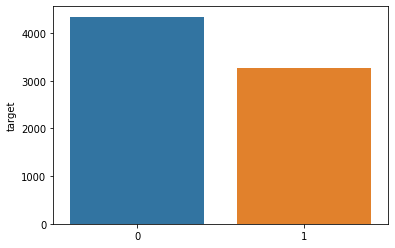

In [ ]:
x=train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
train = train.dropna()
train = train.drop_duplicates()

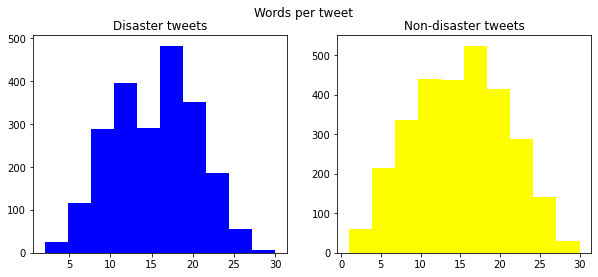

In [ ]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train[train['target']==1]['word_count']
ax1.hist(train_words,color='blue')
ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='yellow')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [ ]:
punct = set(string.punctuation) 

def preprocess_tweet(row):
    text = row['text']
    #Removing unicodes
    text = text.encode(encoding="ascii", errors="ignore")
    text = text.decode()
    text = " ".join([word for word in text.split()])
    #Removing URLs, Hashtags, Punctuation, Mentions, etc.
    text = re.sub("@\S+", "", text)
    text = re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = "".join([ch for ch in text if ch not in punct])
    if '911' not in text:
        text = ''.join([i for i in text if not i.isdigit()])
    return text
    
train['text'] = train.apply(preprocess_tweet, axis=1)

In [ ]:
#Remover espacios, puntuación convertir a minuscula de la columna text
train['text'] = train['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_stop_words(row):
    text = row['text']
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    filtered_sentence = ' '.join((str(n) for n in filtered_sentence))
    return filtered_sentence
    
train['text'] = train.apply(preprocess_stop_words, axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train.head()

,id,keyword,location,text,target,word_count
31,48,ablaze,Birmingham,wholesale markets ablaze,1,5
32,49,ablaze,Est. September 2012 - Bristol,always try bring heavy metal rt,0,10
33,50,ablaze,AFRICA,africanbaze breaking newsnigeria flag set abla...,1,9
34,52,ablaze,"Philadelphia, PA",crying set ablaze,0,7
35,53,ablaze,"London, UK",plus side look sky last night ablaze,0,13


In [ ]:
#Pasar los verbos a singular y generalizarlos (ej: wrecked -> wreck)

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_stemming_lemmatization(row):
    text = row['text']
    temp = text.split()
    for w in range(len(temp)):
        temp[w] = lemmatizer.lemmatize(temp[w])
        temp[w] = stemmer.stem(temp[w])
        
    text = ' '.join((str(n) for n in temp))
    return text

train['text'] = train.apply(preprocess_stemming_lemmatization, axis=1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


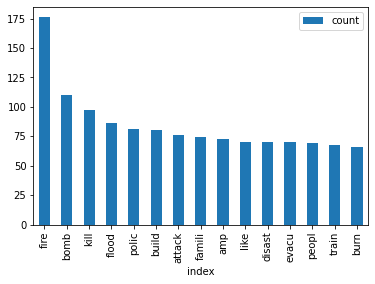

In [ ]:
#Frecuencia de palabras cuando es un desastre natural
desTrain = pd.DataFrame(train[train['target'] == 1].text.str.split(expand=True).stack().value_counts().nlargest(15), columns=['count'])
ax = desTrain.reset_index().plot.bar(x='index', y='count')

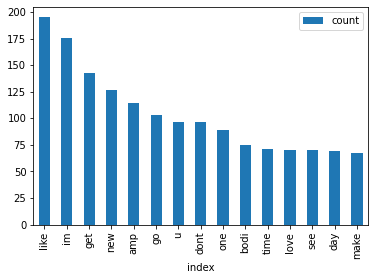

In [ ]:
#Frecuencia de palabras cuando es metaforico
metaTrain = pd.DataFrame(train[train['target'] == 0].text.str.split(expand=True).stack().value_counts().nlargest(15), columns=['count'])
ax = metaTrain.reset_index().plot.bar(x='index', y='count')

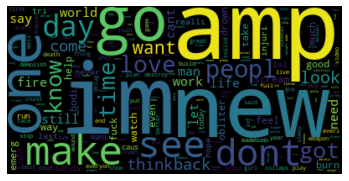

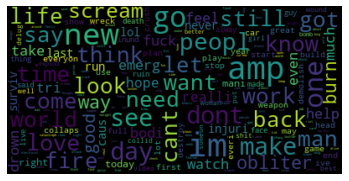

In [ ]:
#ngramas de tweets metaforicos
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(train[train['target'] == 0].text) #Sean metaforicos
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram_meta = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram_meta

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(df_ngram_meta['bigram/trigram']))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(df_ngram_meta['bigram/trigram']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

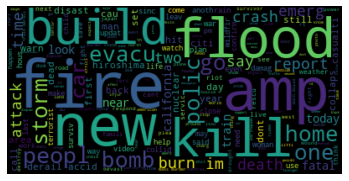

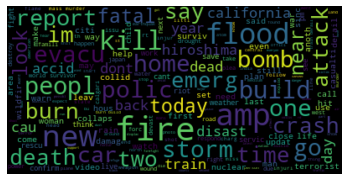

In [ ]:
#ngramas de tweets con desastres reales
stoplist = stopwords.words('english') + ['though']
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3))
# matrix of ngrams
ngrams = c_vec.fit_transform(train[train['target'] == 1].text) #Sean Reales
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram_des = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_ngram_des


# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(df_ngram_des['bigram/trigram']))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(df_ngram_des['bigram/trigram']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
def sentiment_analyse_neg(sentiment_text):
    sentiment_text = sentiment_text['text']
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    return score['neg']

def sentiment_analyse_pos(sentiment_text):
    sentiment_text = sentiment_text['text']
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    return score['pos']

In [ ]:
train['negatividad'] = train.apply(sentiment_analyse_neg, axis=1)
train['positividad'] = train.apply(sentiment_analyse_pos, axis=1)

In [ ]:
train.nlargest(10, 'negatividad')

,id,keyword,location,text,target,word_count,negatividad,positividad
1798,2582,crash,"Kenton, Ohio",ill crash,1,5,1.0,0.0
2141,3073,deaths,Does it really matter!,death,1,3,1.0,0.0
2145,3079,deaths,Does it really matter!,death,0,3,1.0,0.0
3667,5221,fatality,Nairobi,fatal,0,1,1.0,0.0
3670,5224,fatality,Rafael castillo,fatal,0,1,1.0,0.0
3674,5229,fatality,"Enterprise, NV",fatal,0,2,1.0,0.0
3681,5236,fatality,New York,fatal,0,2,1.0,0.0
3686,5245,fatality,"Houston, TX",fatal,0,3,1.0,0.0
3696,5259,fatality,Honduras,fatal,0,2,1.0,0.0
3717,5285,fear,"Thibodaux, LA",worst fear,0,4,1.0,0.0


In [ ]:
train.nlargest(10, 'positividad')

,id,keyword,location,text,target,word_count,negatividad,positividad
4500,6397,hurricane,Vineyard,true gt,1,8,0.0,1.000
4758,6769,lightning,"Rotterdam, The Netherlands",thank thank,0,4,0.0,1.000
6155,8781,siren,"California, USA",save save save heavydirtysoul,0,12,0.0,0.906
6140,8759,siren,Team Slytherin,super sweet beauti,0,6,0.0,0.873
4931,7025,mayhem,"Manavadar, Gujarat",real hero rip brave heart,0,9,0.0,0.848
1473,2122,catastrophe,"New Brunswick, NJ",god bless catastroph,0,3,0.0,0.831
4926,7018,mayhem,"Boston, MA",well know lol,0,6,0.0,0.831
6158,8784,siren,Everywhere,thank join foot,0,7,0.0,0.825
645,935,blaze,Columbus,ye love,0,5,0.0,0.808
6130,8746,siren,London,big love,0,4,0.0,0.808


## BERT - Prediction

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.target.values, test_size=0.1, random_state=2020)

In [ ]:
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []
    for sent in data:
       
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        
            max_length=MAX_LEN,                  
            pad_to_max_length=True,         
            #return_tensors='pt',           
            return_attention_mask=True      
            )

        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([train.text.values, test.text.values])


encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  73


In [ ]:
MAX_LEN = 64
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_test)
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
class BertClassifier(torch.nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

       
        self.bert = BertModel.from_pretrained('bert-base-uncased')

       
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 2)
        )

     
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
def initialize_model(epochs=4):
   
    
    bert_classifier = BertClassifier(freeze_bert=False)

    
    bert_classifier.to(device)

  
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


No GPU available, using the CPU instead.


In [ ]:
import random
import time


loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [ ]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    
    print("Start training...\n")
    for epoch_i in range(epochs):
       
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0

       
        model.train()

        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
               
                time_elapsed = time.time() - t0_batch

              
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

       
        avg_train_loss = total_loss / len(train_dataloader)

        if evaluation == True:
           
            val_loss, val_accuracy = evaluate(model, val_dataloader)

          
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")




In [ ]:
def evaluate(model, val_dataloader):
    model.eval()

  
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
       
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy


In [50]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.645566   |     -      |     -     |  1046.62 
   1    |   40    |   0.539473   |     -      |     -     |  993.45  
   1    |   60    |   0.547097   |     -      |     -     |  988.42  
   1    |   80    |   0.529476   |     -      |     -     |  988.22  
   1    |   100   |   0.492908   |     -      |     -     |  986.40  
   1    |   120   |   0.483284   |     -      |     -     |  988.70  
   1    |   140   |   0.460242   |     -      |     -     |  986.86  
   1    |   142   |   0.486837   |     -      |     -     |   92.23  
   1    |    -    |   0.528533   |  0.437333  |   82.56   |  7324.06 
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------------

KeyboardInterrupt: ignored

In [52]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [53]:

print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [54]:
probs = bert_predict(bert_classifier, test_dataloader)


threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)


print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  394


In [55]:
output = test[preds==1]
list(output.sample(20).text)

['#AUS Aircraft debris found on island is from MH370 Malaysia confirms http://t.co/1zFGk9ET5v #abc',
 'Large sinkhole swallows entire pond in Lowndes County Georgia http://t.co/20Gi4Gyud5',
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/lj4J54vxq3',
 'Chemical spill at a house in Hammondville. Emergency services attending. #BreakingNews #7News http://t.co/bQ94MjYgfe',
 'The death toll in a #IS-suicide car bombing on a #YPG position in the Village of Rajman in the eastern province of Hasaka has risen to 9',
 'No injuries reported after Green Line train derails on South Side http://t.co/nM7HuH3bjC',
 'Two buildings burn in 3-alarm Antioch fire: Two buildings are burning in a 3-alarm fire at the Delta Pines\x89Û_ http://t.co/GQgF2ygpX2',
 'Police: Tennessee theater shooting suspect was 29 http://t.co/CthoDZpLW3 #Philadelphia #News',
 'Ukraine famine memorial in progress since 2006 goes up in Washington: http://t.co/Td7VIEoODi',
 'Hundreds feared drow

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b772f62-55dc-4c06-bba7-f294be65e32f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>